<a href="https://colab.research.google.com/github/karantha-kur/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Analysis

> By Karan Thakur

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing the libraries
import pandas as pd
import re    # for regular expressions
import nltk  # for text manipulation
from nltk.stem.porter import PorterStemmer
import string # for text manipulation
from wordcloud import WordCloud, STOPWORDS
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyspellchecker
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore") #ignore warnings

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding = 'latin-1', header = None)

In [ ]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
df.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [ ]:
print(f'The number of rows are {df.shape[0]}')
print(f'The number of columns are {df.shape[1]}')

The number of rows are 1600000
The number of columns are 6


In [ ]:
df.columns = ['Target', 'Ids', 'Date', 'Flag', 'User', 'Text']
df.head()

,Target,Ids,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


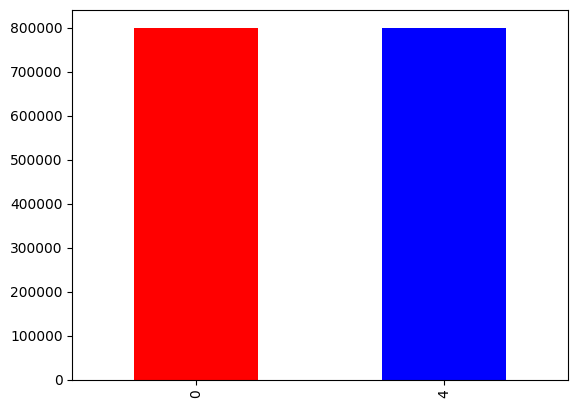

In [ ]:
df['Target'].value_counts().plot(kind='bar', color = ['red', 'blue'])
plt.show()

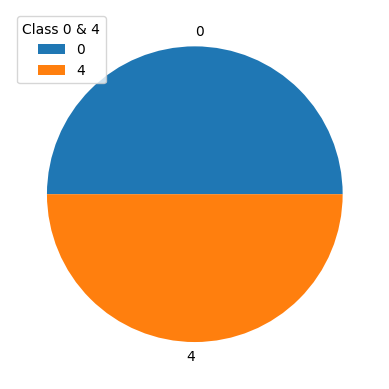

In [ ]:
plt.pie([df['Target'].value_counts()[0],df['Target'].value_counts()[4]], labels=[0,4])
plt.legend(title = 'Class 0 & 4', loc = 'upper left')

In [ ]:
# trying to find relation with length
df_unhappy = df.loc[df['Target'] == 0] # Tag = unhappy
df_happy = df.loc[df['Target'] == 4] # Tag = happy

In [ ]:
avg_len = df['Text'].str.len().mean()
print(f'The average length of tweet is {avg_len}')

The average length of tweet is 74.09011125


In [ ]:
unhappy_wordlen = df_unhappy['Text'].str.split().apply(lambda x: len(x))
happy_wordlen = df_happy['Text'].str.split().apply(lambda x: len(x))
print(f'The average of Fake class is {unhappy_wordlen.mean()}')
print(f'The average of Real class is {happy_wordlen.mean()}')

The average of Fake class is 13.58198375
The average of Real class is 12.7703175


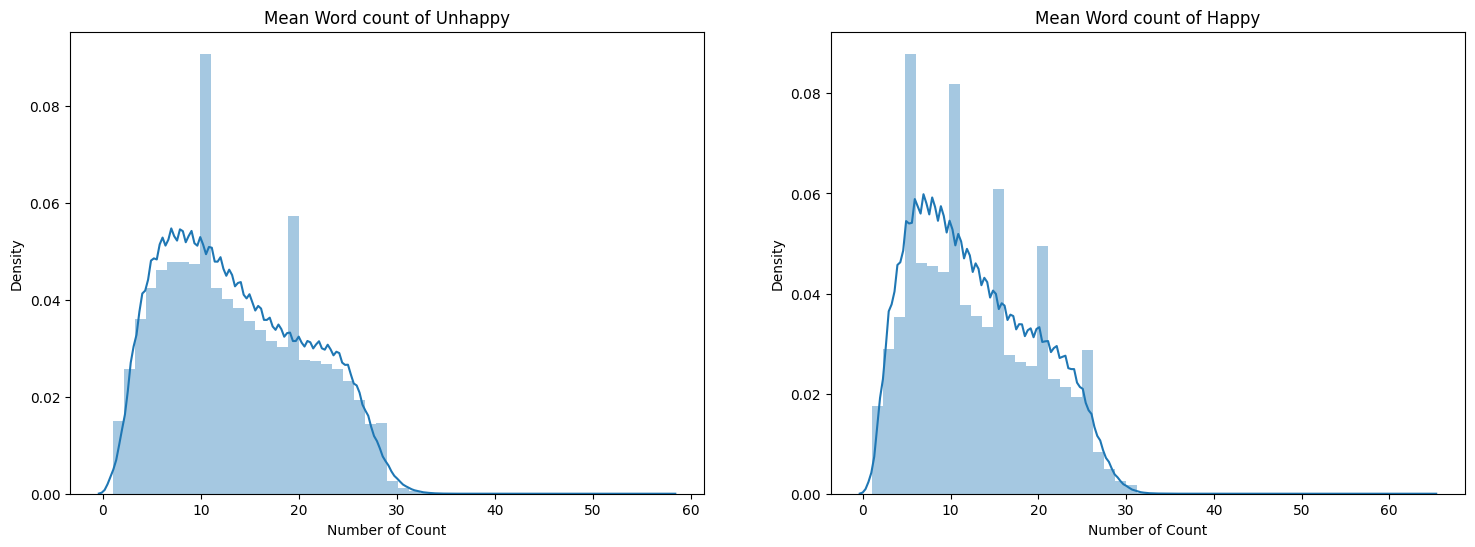

In [ ]:
# mean word count of both classses
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('Mean Word count of Unhappy')
sns.distplot(unhappy_wordlen.map(lambda x: np.mean(x)))
plt.xlabel('Number of Count')
plt.subplot(122)
plt.title('Mean Word count of Happy')
sns.distplot(happy_wordlen.map(lambda x: np.mean(x)))
plt.xlabel('Number of Count')
plt.show()

In [ ]:
df1 = df.drop(['Ids', 'Date', 'Flag', 'User'], axis = 1) #create a new dataframe with only the targte and text
df1.head()

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
df_positive_tweet = df1[df1['Target'] == 4].iloc[:18000, :]
df_negative_tweet = df1[df1['Target'] == 0].iloc[:2000, :]
print(df_positive_tweet.shape)
print(df_negative_tweet.shape)

(18000, 2)
(2000, 2)


In [ ]:
df_tweetdata = pd.concat([df_positive_tweet, df_negative_tweet],axis = 0)
print(f' The number of rows in new dataset is {df_tweetdata.shape[0]}')
print(f' The number of columns in new dataset is {df_tweetdata.shape[1]}')
df_tweetdata.reset_index()
df_tweetdata.head()

 The number of rows in new dataset is 20000
 The number of columns in new dataset is 2


,Target,Text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [ ]:
df_tweetdata.isna()

,Target,Text
800000,False,False
800001,False,False
800002,False,False
800003,False,False
800004,False,False
...,...,...
1995,False,False
1996,False,False
1997,False,False
1998,False,False


In [ ]:
df_tweetdata.isna().sum()

Target    0
Text      0
dtype: int64

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
def remove_stopword(text):
    lst = ' '
    clean_text = lst.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [ ]:
def Tweets_cleanup(df_tweetdata):
    str_1 = ''
    str_2 = ' '
    df_tweetdata['Clean_text'] = df_tweetdata['Text'].str.replace("@", str_1)  # Remove handle (@)
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].str.replace(r"http\S+", str_1) # Remove all Links (https...)
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].str.replace("[^a-zA-Z]", str_2) # Remove Punctuations & Special characters
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].apply(lambda text : remove_stopword(text.lower())) # Remove the Stop words
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].apply(lambda lm: lm.split()) # Split the text and tokenize it
    stemmer = PorterStemmer()
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].apply(lambda lm: [stemmer.stem(i) for i in lm]) # Now apply Stemmer (Porter)
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].apply(lambda lm: ' '.join([w for w in lm]))  # Stitch back words
    df_tweetdata['Clean_text'] = df_tweetdata['Clean_text'].apply(lambda lm: ' '.join([w for w in lm.split() if len(w)>3])) # Remove small words

In [ ]:
Tweets_cleanup(df_tweetdata)
df_tweetdata.head()

,Target,Text,Clean_text
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet best
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet besti tonight cant wait girl talk
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter sunisa meet show area sweetheart
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much real food friend make soup
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


In [ ]:
def create_wordcloud(targ):
    df2 = pd.DataFrame()
    if (targ == -1) :
        df2 = df_tweetdata
    else:
        df2 = df_tweetdata[df_tweetdata.Target == targ]
    word = " ".join(df2.Clean_text)
    word_cloud = WordCloud(stopwords = STOPWORDS, width = 1500, background_color = 'black', height = 1000).generate(word)
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

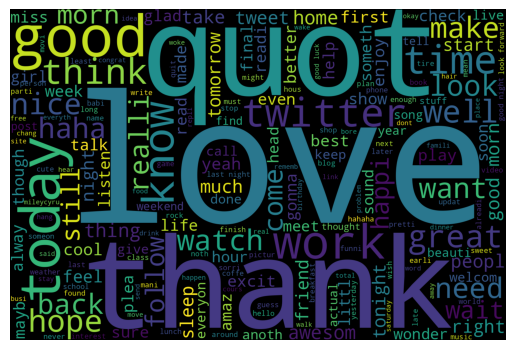

In [ ]:
create_wordcloud(4)

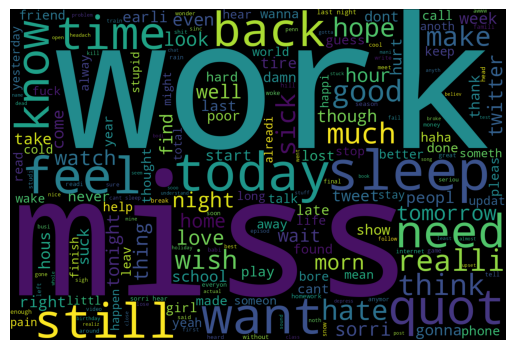

In [ ]:
create_wordcloud(0)

In [ ]:
# training the model begins
df_tweetdata.head()

,Target,Text,Clean_text
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet best
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet besti tonight cant wait girl talk
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter sunisa meet show area sweetheart
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much real food friend make soup
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


In [ ]:
def PieChart(df):
    cnt = 100 * df.value_counts()
    cnt /= len(df)
    # Set the data for pie chart
    Labels = df.value_counts().index.values
    sizes =  cnt

    # Set the Labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels = Labels,  shadow = True, startangle = 90, autopct = '%1.2f%%')
    ax1.axis('equal')  # Aspect ratio Equal shows that pie is drawn as a circle.
    plt.show()

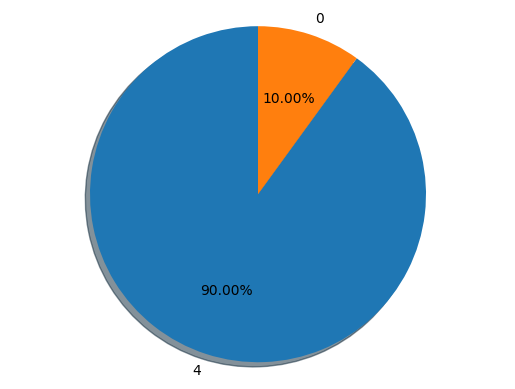

In [ ]:
PieChart(df_tweetdata['Target'])

In [ ]:
df_tweetdata.head()

,Target,Text,Clean_text
800000,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet best
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet besti tonight cant wait girl talk
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter sunisa meet show area sweetheart
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much real food friend make soup
800004,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


In [ ]:
df_tweet_train, df_tweet_test = train_test_split(df_tweetdata, test_size=0.3, random_state=42)

In [ ]:
df_tweet_train.shape

(14000, 3)

In [ ]:
df_tweet_test.shape

(6000, 3)

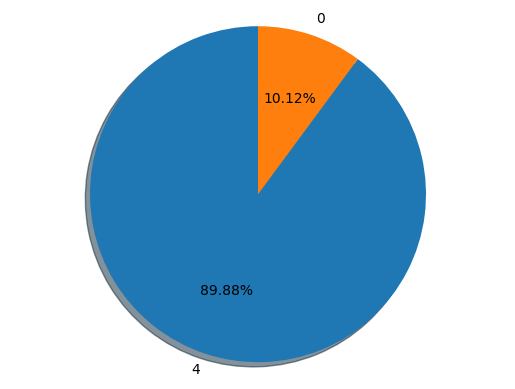

In [ ]:
PieChart(df_tweet_train['Target'])

In [ ]:
#convert data into list
lst_tweet_train =[]
lst_tweet_test =[]

for twet in df_tweet_train.Clean_text:
    lst_tweet_train.append(twet)

for twet in df_tweet_test.Clean_text:
    lst_tweet_test.append(twet)

In [ ]:
lst_tweet_train[:10]

['today fell love amaz',
 'bransonpro',
 'ladybug love video laura',
 'charley cute sweet blue cheer tweeter',
 'lypti yeah rephotograph older stock list store design today',
 'derek shwe sweet except stretch browser watch twit',
 'activ facebook account remov iphon good feel overal realli',
 'twitter',
 'noth like come back work sick much catch oniisan shave',
 'megan rais hand friend either twitter excit live']

In [ ]:
lst_tweet_test[:10]

['noellegray haha mine transform accord small',
 'missygail argu sinc know chang opinion',
 'mileycyru amaz thank much sweet take thank compliment haha',
 'twilight book pretti addict chapter time sleep good night tweep',
 'sleep mode initi long ahead hope thing share tomorrow anyon want anyth know',
 'techcrunch mike gotta women compet date',
 'cheeseach linux fine want glorifi calcul',
 'aint fast aint what wait side climb love miley cyru',
 'look seem complet differ config find share host hard control',
 'aplusk sorri mean misspelllll twitter name']

In [ ]:
vectorizer = TfidfVectorizer()
tweet_tfidf_train = vectorizer.fit_transform(lst_tweet_train)
tweet_tfidf_test = vectorizer.transform(lst_tweet_test)

In [ ]:
vectorizer

TfidfVectorizer()

In [ ]:
df_train_tfidf = pd.DataFrame(tweet_tfidf_train.toarray(), columns = vectorizer.get_feature_names_out())
print(df_train_tfidf.shape)
df_train_tfidf.head()

(14000, 17367)


,aaaaaa,aaaaag,aaaaand,aaaah,aaaand,aaah,aaand,aaaw,aaaww,aabink,...,zukyleigh,zulkey,zulu,zuraidah,zurairi,zurich,zuzusu,zzap,zzzz,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# all the models being used
classifiers = [KNeighborsClassifier(n_neighbors = 5),
              DecisionTreeClassifier(),
              MultinomialNB(),
              RandomForestClassifier(n_estimators = 1000, random_state = 42),
              LogisticRegression(),
              svm.SVC()]
class_name = []

In [ ]:
# fitting and accuracy of all models
label_actual = df_tweet_test['Target']
temp = 0
accuracy = []
for clf in classifiers :
    model = clf.fit(tweet_tfidf_train, df_tweet_train['Target'])
    label_predicted = model.predict(tweet_tfidf_test)
    cnt = (100 * accuracy_score(label_predicted, label_actual))
    cnt = round(cnt,2)
    accuracy.append(cnt)
    class_name.append(clf.__class__.__name__)
    print (f'{class_name[temp]}  Accuracy Score : {cnt}')
    print (classification_report(label_predicted, label_actual))
    temp +=1

KNeighborsClassifier  Accuracy Score : 89.88
              precision    recall  f1-score   support

           0       0.04      0.33      0.07        70
           4       0.99      0.91      0.95      5930

    accuracy                           0.90      6000
   macro avg       0.52      0.62      0.51      6000
weighted avg       0.98      0.90      0.94      6000

DecisionTreeClassifier  Accuracy Score : 85.9
              precision    recall  f1-score   support

           0       0.27      0.27      0.27       583
           4       0.92      0.92      0.92      5417

    accuracy                           0.86      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.86      0.86      0.86      6000

MultinomialNB  Accuracy Score : 90.3
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           4       1.00      0.90      0.95      5999

    accuracy                           0.90      6000
